#Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [ ]:
import os
import sys
import random
import warnings
import pandas as pd
import math
import cv2
import skimage
from skimage import data
from skimage import io
import datetime
from math import *
from matplotlib import pyplot
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import ELU
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense,ZeroPadding2D,Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam,Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import regularizers
import imgaug as ia
from imgaug import augmenters as iaa
import albumentations as A
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from imgaug import augmenters as iaa
!pip install -q -U tensorflow_addons
!pip install shutils
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from shutil import copyfile
import shutils
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras.preprocessing import image
from os import listdir
from os.path import isfile, join
import re
from tensorflow.keras.preprocessing.image import img_to_array

# Augmentation

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.75), # horizontally flip
    iaa.Sometimes(0.25, iaa.GaussianBlur((0, 3.0))),
    MY_augmenter,
    # apply Gaussian blur with a sigma between 0 and 3 to 50% of the images
    # apply one of the augmentations: Dropout or CoarseDropout

     iaa.OneOf([
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
        # iaa.Noop(),
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        # iaa.Noop(),
        iaa.Affine(rotate=(-10, 10), translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0))
        # iaa.Noop(),
        # iaa.PerspectiveTransform(scale=(0.04, 0.08)),
        # # iaa.Noop(),
        # iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0)),

    ]),

      iaa.SomeOf((0, 5),[
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
        iaa.Fliplr(1.0), # horizontally flip
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0.25))), # crop and pad 50% of the images
        iaa.Sometimes(0.5, iaa.Affine(rotate=(-10, 10), translate_percent={"x": (-0.25, 0.25)},
                                      mode='symmetric', cval=(0))) ]),
        iaa.Solarize(0.5, threshold=(32, 128)),

], random_order=True)

######

MY_augmenter = iaa.Sometimes(0.5,iaa.Lambda(

                             func_keypoints=func_keypoints,
                              ))

# Load Images

**RAF-DB and CK+ images sorted into 7 classes**

## CK+

####  For  training model on CK+,
####  only run the K-FOLD Cross Validation cell
####  corresponding to CK+ Train section which
####  includes splitting, generating images and training  don't run next.

In [ ]:
'''
TRAIN_DIR = '/CK+/'

def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

## convert into dataframe
df = pd.DataFrame()
df['image'], df['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = df.sample(frac=1).reset_index(drop=True)
train.head()
'''


## RAF-DB & FER2013

In [ ]:
# RAF-DB
num_classes = 7
img_rows, img_cols = 100,100
batch_size = 64
train_data_dir = '/raf_data/train'
validation_data_dir ='/raf_data/validation'

'''
#FER-2013
num_classes = 7
img_rows, img_cols = 48,48
batch_size = 64
train_data_dir = '/fer2013/train'
validation_data_dir ='/fer2013/validation'
'''

train_datagen = ImageDataGenerator(
                                   rescale=1./512,
                                   preprocessing_function=MY_augmenter,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                    )

validation_datagen = ImageDataGenerator(rescale=1./512)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        class_mode='categorical',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        class_mode='categorical',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        shuffle=True)


# MODEL

## Side Branch

In [ ]:
l2=tf.keras.regularizers.l2(1e-3)
kernel_init = tf.keras.initializers.he_normal()
bias_init = tf.keras.initializers.Constant(value=0.1)

In [ ]:
 def auxilliary_module1(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='aux1'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='aux1')

    return output

In [ ]:
 def auxilliary_module2(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='aux2'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='aux2')

    return output

## Main Branch

In [ ]:
 model = Sequential()
input_layer = Input(shape=(img_rows, img_cols, 1))
input_half_1 = AveragePooling2D(pool_size=(2, 2), padding='valid')(input_layer)

########################################
#Block Conv 1
x=Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv_10')(input_layer)
x=Activation('elu')(x)
x=BatchNormalization()(x)
x=Dropout(0.25)(x)
x=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal",name='conv_11')(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv_12')(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal",name='conv_13')(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)
x=Dropout(0.25)(x)
x=AveragePooling2D(pool_size=(2, 2))(x)

x1= concatenate([x, input_half_1])
########
# Side Branch
i1 = auxilliary_module1(x1,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='aux1')

i2 = auxilliary_module2(i1,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='aux2')

i4 = AveragePooling2D(pool_size=(5, 5), padding='same')(i2)

#### End of Side Branch layers###
#################################
#Block Conv 2
x2=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv_20')(x1)
x2=Activation('elu')(x2)
x2=BatchNormalization()(x2)
x2=Dropout(0.25)(x2)
x2=Conv2D(128, (1,1), padding = "same", kernel_initializer="he_normal",name='conv_21')(x2)
x2=ZeroPadding2D((1, 1))(x2)
x2=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv_22')(x2)
x2=Activation('elu')(x2)
x2=BatchNormalization()(x2)
x2=Dropout(0.5)(x2)
x2=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv_23')(x2)
x2=Activation('elu')(x2)
x2=BatchNormalization()(x2)
x2=Dropout(0.25)(x2)
x2= AveragePooling2D(pool_size=(2, 2))(x2)

resi_1=AveragePooling2D(pool_size=(2, 2))(x2)

###############
#Block Conv 3
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv_30')(x2)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Dropout(0.25)(x3)
x3=Conv2D(256, (1,1), padding = "same", kernel_initializer="he_normal",name='conv_31')(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv_32')(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Dropout(0.5)(x3)
x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv_33')(x3)
x3=Activation('elu')(x3)
x3=BatchNormalization()(x3)
x3=Dropout(0.25)(x3)
x3=AveragePooling2D(pool_size=(2, 2)) (x3)

x4=concatenate([x3,resi_1])

###############
#Block Conv 4
x5=ZeroPadding2D((1, 1))(x4)
x5=Conv2D(512, (3, 3), padding = 'same', kernel_initializer="he_normal",name='conv_40')(x5)
x5=Activation('elu')(x5)
x5=BatchNormalization()(x5)
x5=Dropout(0.25)(x5)
x5=Conv2D(512, (1,1), padding = "same", kernel_initializer="he_normal",name='conv_41')(x5)
x5=Conv2D(512, (3, 3), padding = 'valid', kernel_initializer="he_normal",name='conv_42')(x5)
x5=Activation('elu')(x5)
x5=BatchNormalization()(x5)
x5=Dropout(0.25)(x5)
x5 =AveragePooling2D(pool_size=(2, 2),padding='same')(x5)
#####################
#Block DecConv
dc_1 = Conv2DTranspose(512, (4, 4), activation='elu',strides=1,
      padding = 'valid',kernel_initializer='he_normal', name='deconv_01')(x5)

dc_1_con=concatenate([i4,dc_1])

dc_1 = UpSampling2D((2,2))(dc_1_con)
dc_2 = Conv2DTranspose(256, (3, 3),padding = 'same', activation='elu',strides=1,
     dilation_rate=(1,1),kernel_initializer='he_normal',  name='deconv_02')(dc_1)
dc_2 = UpSampling2D((2,2))(dc_2)
#####################
#Block Dense Layers
x6 = Flatten()(dc_2)
x6 = Dense(512, activation='elu',name='dense1')(x6)
x6 =BatchNormalization()(x6)
x6 = Dropout(0.4)(x6)
x6 = Dense(512, activation='elu',name='dense2')(x6)
x6 =BatchNormalization()(x6)
x6 = Dropout(0.2)(x6)

out = Dense(num_classes, activation='softmax',kernel_initializer="he_normal")(x6)
#############
#############
model = Model(input_layer, [out], name='Model')
#model.summary()

# Training Functions

## Callback

In [ ]:
def decay(epoch, steps=50):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+(2*epoch)/epochs_drop)))
    return lrate
###
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback
####
checkpoint = ModelCheckpoint("/weights.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=0)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 0,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.96,
                              patience=4, min_lr=1e-6, verbose=1)

lr_sc = LearningRateScheduler(decay,verbose=0)

####

callback = [earlystop
              ,checkpoint
              ,reduce_lr
              ,lr_sc
              ,create_tensorboard_callback(dir_name="tensorflow_hub",  experiment_name="Emotion Detection")]


## Class Weight

In [ ]:
labels_dict = {0: 281,1: 705,2: 717,3:4772,4:2524,5:1982,6:1290} #number of each class
labels_dict2 = { 0:1.0 , 1:1.0 , 2:1.0, 3:1.0 , 4:1.0 , 5:1.0 , 6:1.0} #We can change values by choosing a value [0,1] assign the class worthinessfor computation

def create_class_weight(labels_dict,alpha=2):  # We can change alpha. The default valus of hyperparameter alpha is taken 2
    total = np.sum (list(labels_dict.values()))
    keys = labels_dict.keys()
    keys = labels_dict2.keys()
    class_weight = dict()

    numberb_training_samples=12271 # RAF-DB training samples
    #numberb_training_samples=28717 # FER-2013 training samples

    for key in keys:

        score1 =tf.math.abs( tf.math.reduce_logsumexp((alpha*(nb_train_samples/float(labels_dict[key]*labels_dict2[key])))))
        score =(tf.math.round(((score1))/int(res)).numpy())+1
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

max_value = max(labels_dict.values())
min_value = min(labels_dict.values())
mean=tf.math.squared_difference(max_value,min_value).numpy()+1
a = tf.constant([ mean], dtype = tf.float32)
res = tf.math.round(tf.math.sqrt(a)).numpy()
res=tf.math.log(res).numpy()
print(res)

create_class_weight(labels_dict)

class_weights = create_class_weight(labels_dict)

4772
281
[8.409831]


{0: 256.0, 1: 11.0, 2: 11.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 7.0}

# Training RAF-DB & FER-2013 CELL

In [ ]:

model.compile(
              loss = ['categorical_crossentropy'],
              optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics = ['accuracy'])

#RAF-DB
nb_train_samples = 12271
nb_validation_samples = 3068

'''
#FER-2013
nb_train_samples = 28831
nb_validation_samples = 7157
'''

epochs =30
batch_size=64

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    epochs = epochs,
    callbacks = callback,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size,
    class_weight=class_weights,
    workers=8)

Saving TensorBoard log files to: tensorflow_hub/mod2/20230608-235307
Epoch 1/30


127/127 [==============================] - 95s 576ms/step - loss: 1.7121 - accuracy: 0.9902 - val_loss: 0.4272 - val_accuracy: 0.8508 - lr: 5.0000e-05
Epoch 2/30
127/127 [==============================] - 69s 541ms/step - loss: 1.5304 - accuracy: 0.9911 - val_loss: 0.4190 - val_accuracy: 0.8306 - lr: 5.0000e-05
Epoch 3/30
127/127 [==============================] - 74s 586ms/step - loss: 1.5448 - accuracy: 0.9902 - val_loss: 0.4095 - val_accuracy: 0.8669 - lr: 5.0000e-05
Epoch 4/30
127/127 [==============================] - 72s 570ms/step - loss: 1.4699 - accuracy: 0.9902 - val_loss: 0.4014 - val_accuracy: 0.8710 - lr: 5.0000e-05
Epoch 5/30
127/127 [==============================] - 73s 579ms/step - loss: 1.7625 - accuracy: 0.9941 - val_loss: 0.3981 - val_accuracy: 0.8548 - lr: 2.5000e-05
Epoch 6/30
127/127 [==============================] - 68s 536ms/step - loss: 1.4631 - accuracy: 0.9892 - val_loss: 0.3951 - val_accuracy: 0.8629 - lr: 2.5000e-05
Epoch 7/30
127/127 [===================

# Training CK+ K-FOLD CROSS VALIDATION

In [ ]:
# Hyper Parameters
IMG_SIZE = 100
BATCH_SIZE = 64
EPOCHS = 30
N_SPLIT = 10

# Storing the average of all predictions
main_pred = []
data_kfold = pd.DataFrame()
cv = []
cv_loss = []

# Creating X, Y for training
train_y = df['label']
train_x = df['image']

##################################
#Initializing Data Generators

train_datagen = ImageDataGenerator(rescale = 1./512,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)


# k-fold
kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)

j = 0
# K-fold Train and test for each split

for train_idx, val_idx in list(kfold.split(train_x,train_y)):

    x_train_df = df.iloc[train_idx]

    x_valid_df = df.iloc[val_idx]

    j+=1

    training_set=train_datagen.flow_from_dataframe(
                                                 dataframe=train,
                                                 directory=TRAIN_PATH,
                                                 x_col="image",
                                                 y_col="label",
                                                 subset="training",
                                                 batch_size=BATCH_SIZE,
                                                 color_mode = 'grayscale',
                                                 seed=42,
                                                 shuffle=True,
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE))

    validation_set = train_datagen.flow_from_dataframe( dataframe=train,
                                                 directory=TRAIN_PATH,
                                                 x_col="image",
                                                 y_col="label",
                                                 subset="validation",
                                                 batch_size=BATCH_SIZE,
                                                 color_mode = 'grayscale',
                                                 seed=42,
                                                 shuffle=True,
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE))

    test_set = train_datagen.flow_from_dataframe( dataframe=train,
                                                 directory=TRAIN_PATH,
                                                 x_col="image",
                                                 y_col="label",
                                                 subset="validation",
                                                 batch_size=1,
                                                 color_mode = 'grayscale',
                                                 seed=42,
                                                 shuffle=True,
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE))



    model.compile(
                  loss = ['categorical_crossentropy'],
                  optimizer = Adam(learning_rate=0.002,clipnorm=0.001),
                  metrics = ['accuracy'])

    history = model.fit_generator(
                                    training_set,
                                    steps_per_epoch= training_set.samples // BATCH_SIZE,
                                    epochs= EPOCHS,
                                    validation_data=validation_set,
                                    validation_steps = validation_set.samples // BATCH_SIZE,
                                    workers=8,
                                    callbacks = mycallback,
                                             )

    scores= model.evaluate(test_set, verbose=1)
    print('Test loss:', pred[0])
    print('Test accuracy:', pred[1])
    print('%s: %.2f%%' % (model.metrics_names[1],scores[1] * 100 ))
    cv.append(scores[1])
    cv_loss.append(scores[0])
    predicted_class_indices=np.argmax(scores,axis=0)
    data_kfold[j] = predicted_class_indices
    gc.collect()

# == Provide average scores ==

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(cv)):

  print('------------------------------------------------------------------------')
  #print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print(f'> Fold {i+1} - Accuracy: %.2f%%' % (cv[i] * 100 ))
print('------------------------------------------------------------------------')

print('Average Accuracy for all Folds:')
print(f'> Accuracy: %.2f%% std:(+/- %.3f%%)' % (np.mean(cv), np.std(cv)))
#print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Found 793 validated image filenames belonging to 7 classes.
Found 198 validated image filenames belonging to 7 classes.
Found 198 validated image filenames belonging to 7 classes.
Saving TensorBoard log files to: tensorflow_hub/mod2/20220911-224230
Epoch 1/30
49/49 [==============================] - 81s 1s/step - loss: 0.6651 - accuracy: 0.6692 - val_loss: 0.6584 - val_accuracy: 0.1562 - lr: 5.0000e-05
Epoch 2/30
49/49 [==============================] - 12s 233ms/step - loss: 0.6116 - accuracy: 0.8366 - val_loss: nan - val_accuracy: 0.1198 - lr: 5.0000e-05
Epoch 3/30
49/49 [==============================] - 41s 838ms/step - loss: 0.5642 - accuracy: 0.9060 - val_loss: 0.5673 - val_accuracy: 0.3594 - lr: 5.0000e-05
Epoch 4/30
49/49 [==============================] - 41s 847ms/step - loss: 0.5206 - accuracy: 0.9575 - val_loss: 0.5121 - val_accuracy: 0.7188 - lr: 5.0000e-05
Epoch 5/30
49/49 [==============================] - 40s 823ms/step - loss: 0.4905 - accuracy: 0.9601 - val_loss: 0.50

# Visualizartion

## RAF-DB

### Tensorboard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./"tensorflow_hub" \
--name "resnet50V2" \
--description "Comparing two dion models architectures using 10% of training images" \
--one_shot

2023-06-09 00:23:00.214020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   VVTW-TQJH



New experiment created. View your TensorBoard at: https://tensorboard.dev/exper

### Confusin Matrix

Found 3068 images belonging to 7 classes.
48/48 [==============================] - 14s 283ms/step
Confusion Matrix
[[ 135    5    1    9    7    3    2]
 [  15   85    0   15   25   15    5]
 [   4    0   44    4    4    5   13]
 [   1    7    2 1128   37    3    7]
 [   1    8    0   23  599   31   18]
 [   3   10    1   15   38  409    2]
 [   4    5    8    8   20    3  281]]
Classification Report
              precision    recall  f1-score   support

       angry       0.83      0.83      0.83       162
     disgust       0.71      0.53      0.61       160
        fear       0.79      0.59      0.68        74
       happy       0.94      0.95      0.95      1185
     neutral       0.82      0.88      0.85       680
         sad       0.87      0.86      0.86       478
    surprise       0.86      0.85      0.86       329

    accuracy                           0.87      3068
   macro avg       0.83      0.79      0.80      3068
weighted avg       0.87      0.87      0.87      3068


<Axes: >

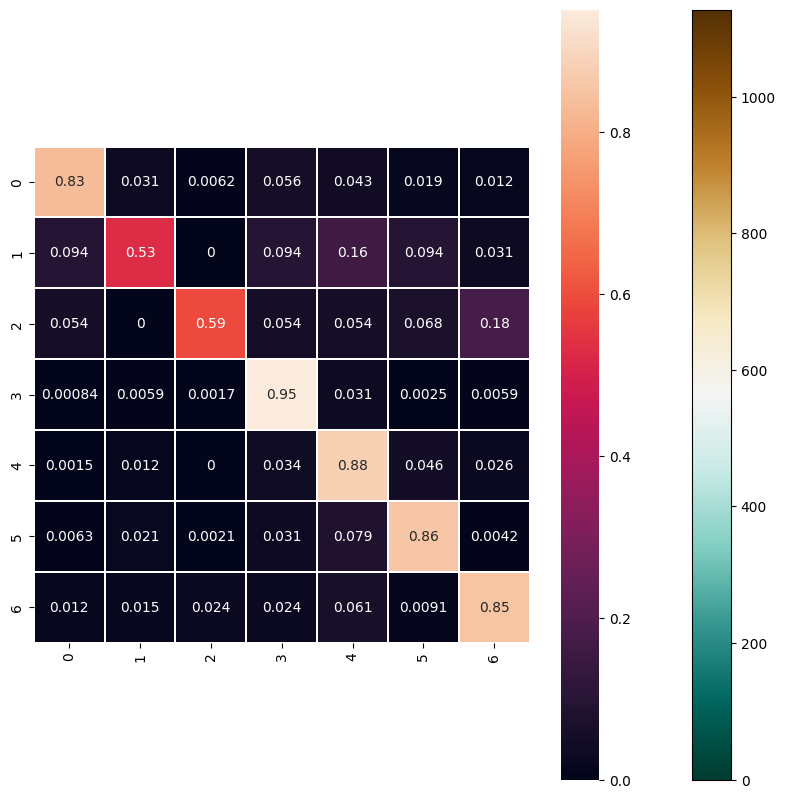

In [ ]:
nb_train_samples = 12271
nb_validation_samples = 3068

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes,y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(10,10))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.BrBG_r)
plt.colorbar()

tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
#Create normalized Confusion Matrix
import seaborn as sns
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, linewidths = 0.01)

## FER-2013

### Confusion Matrix


Found 7157 images belonging to 7 classes.
224/224 [==============================] - 15s 66ms/step
Confusion Matrix
[[ 900    0   15    6   11   24    2]
 [  14   99    2    0    9    4    0]
 [  31    2  930    3   21   27   10]
 [   5    0    5 1726   15   12   11]
 [  17    0   15   19 1108   31    5]
 [  25    0   32   12   34 1142    2]
 [   2    0   16    3    6    2  802]]
Classification Report
              precision    recall  f1-score   support

       angry       0.91      0.94      0.92       958
     disgust       0.98      0.77      0.86       128
        fear       0.92      0.91      0.91      1024
       happy       0.98      0.97      0.97      1774
     neutral       0.92      0.93      0.92      1195
         sad       0.92      0.92      0.92      1247
    surprise       0.96      0.97      0.96       831

    accuracy                           0.94      7157
   macro avg       0.94      0.91      0.93      7157
weighted avg       0.94      0.94      0.94      7157

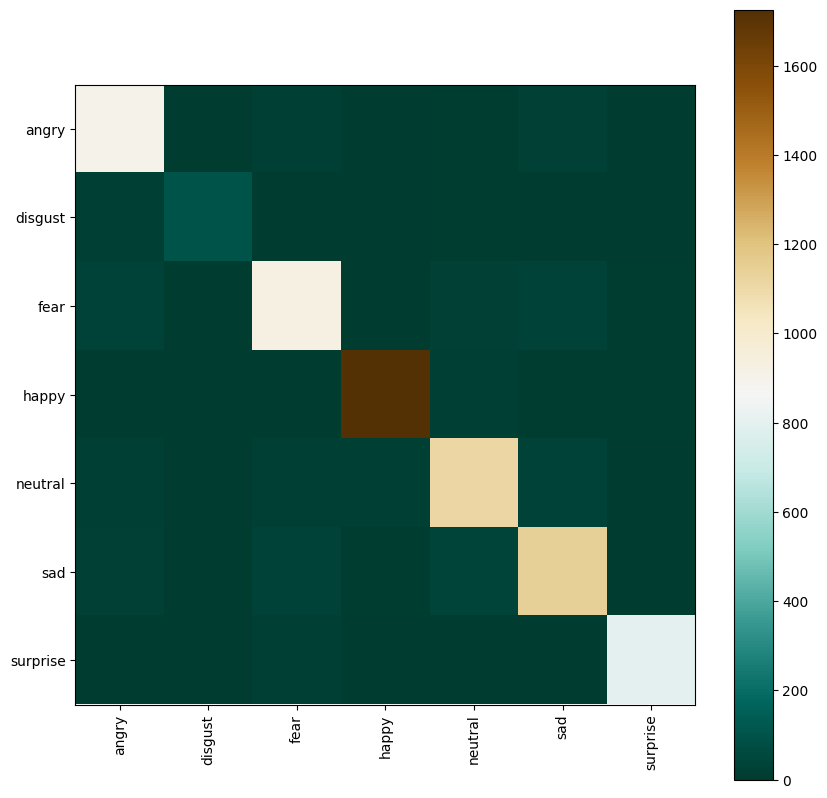

In [ ]:
nb_train_samples = 28831
nb_validation_samples = 7157

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)


class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

Y_pred = model.predict(validation_generato)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes,y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(10,10))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.BrBG_r)
plt.colorbar()

tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)


<Axes: >

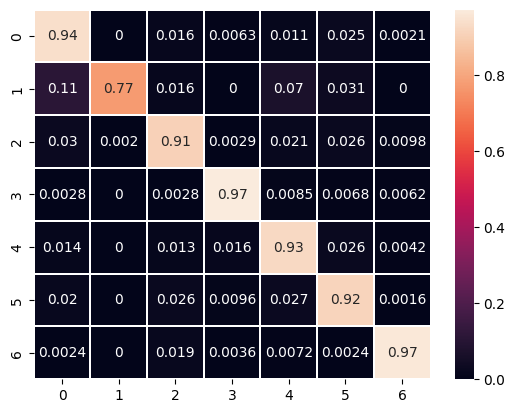

In [ ]:
#Create normalized Confusion Matrix
import seaborn as sns
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, linewidths = 0.01)

### Plots

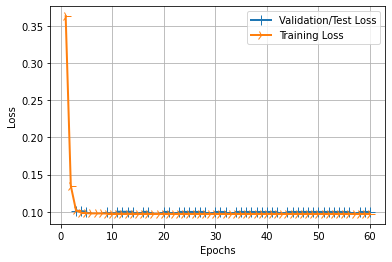

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

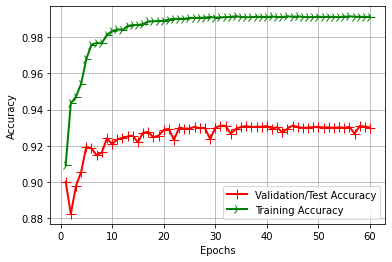

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, color='r',label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values,color='g', label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## CK+

### Confusion Matrix

Found 196 validated image filenames belonging to 7 classes.
13/13 [==============================] - 1s 63ms/step
Confusion Matrix
[[28  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0]
 [ 0  0 11  0  0  0  0]
 [ 0  0  0 48  0  0  0]
 [ 0  0  0  0 11  0  0]
 [ 0  0  0  0  0 19  0]
 [ 0  0  0  0  0  0 51]]
Classification Report
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        28
     disgust       1.00      1.00      1.00        28
        fear       1.00      1.00      1.00        11
       happy       1.00      1.00      1.00        48
     neutral       1.00      1.00      1.00        11
         sad       1.00      1.00      1.00        19
    surprise       1.00      1.00      1.00        51

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196



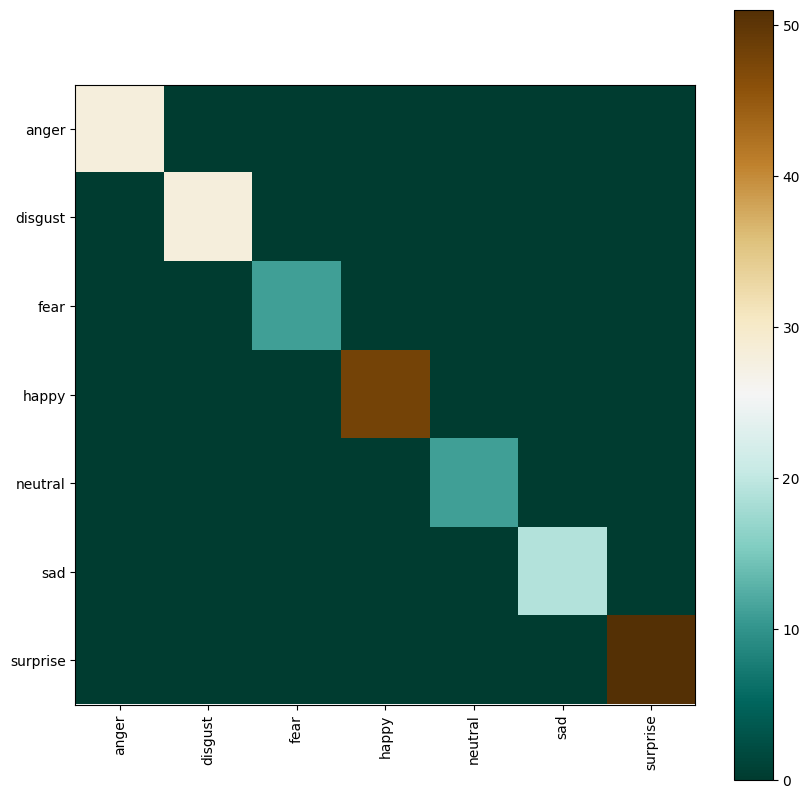

In [ ]:
validation_set = train_datagen.flow_from_dataframe( dataframe=train,
                                                 directory=TRAIN_PATH,
                                                 x_col="image",
                                                 y_col="label",
                                                 subset="validation",
                                                 batch_size=BATCH_SIZE,
                                                 color_mode = 'grayscale',
                                                 seed=42,
                                                 shuffle=False,
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE))


class_labels = validation_set.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_set,batch_size=64, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_set.classes,y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(10,10))
cnf_matrix = confusion_matrix(validation_set.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.BrBG_r)
plt.colorbar()

tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)


<Axes: >

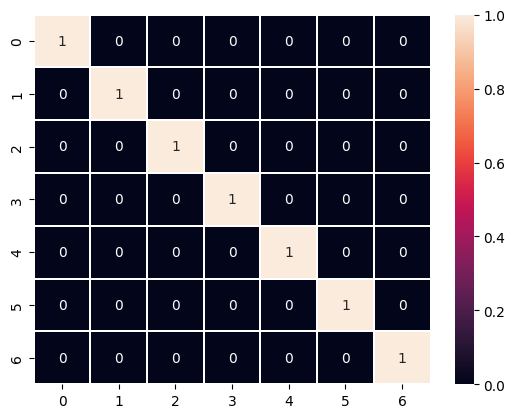

In [ ]:
#Create normalized Confusion Matrix
import seaborn as sns
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, linewidths = 0.01)

### Plots

In [ ]:
#Tensorboard Address
!tensorboard dev upload --logdir ./"tensorflow_hub" \
--name "resnet50V2" \
--description "Comparing two dion models architectures using 10% of training images" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=ZThiHluuVdiuzYHELYqK77MkwnMBaI&prompt=consent&access_type=offl

## Visualization Of Expression Detection on Some Images

In [ ]:
def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale=True), final_path, path_class

# dimensions of images
img_width, img_height = 48, 48

#Compile
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = './fer2013/validation/'
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)

for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

## Test on One Image

In [ ]:
%matplotlib inline

face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img

    allfaces = []
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

img = cv2.imread("images-6.jpg")
rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    #prediction on the ROI
    preds = model.predict(roi)[0]
    label = class_labels[preds.argmax()]
    print(class_labels)
    print(preds)
    print("label:",label)
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
cv2.imshow("Emotion Detector", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
[0.04710943 0.00505322 0.06753542 0.22823681 0.54270786 0.08355253
 0.02580479]
label: neutral
